# Victor Manuel Gómez Espinosa
## CIMAT Unidad Monterrey
### Clusters de Tópicos de Riesgos a la Alza y Baja de 2011-2020

Para el correcto funcionamiento, todos los archivos y embeddings deben estar en la misma carpeta de Colab y estar activada la conexión con Gdrive

In [ ]:
#instalacion de librerias
!pip install fasttext
!pip install sklearn_extensions

     |████████████████████████████████| 71kB 4.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094769 sha256=5f303132d91b70c2bbe18990224eef2df03073709b23ff47804a753a11d367d3
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
  Created wheel for sklearn-extensions: filename=sklearn_extensions-0.0.2-py2.py3-none-any.whl size=24578 sha256=d4891297e44e232731cb161153d4d4ac095305d58ef1e152ceb16d862cdd1f0c
  Stored in directory: /root/.cache/pip/wheels/b5/26/b2/09100728168b45e4de834b943a588028744fdfaa9ac979ffb2
Successfully built sklearn-extensions


In [ ]:
#librerias
import os
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
#from gensim.models.keyedvectors import KeyedVectors
import fasttext.util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA,KernelPCA
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopSpanish=set(stopwords.words('spanish'))
from sklearn_extensions.fuzzy_kmeans import FuzzyKMeans
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from ipywidgets import interact
from sklearn.neighbors import NearestNeighbors
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.



[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
os.chdir('/content/drive/My Drive/Colab') #cambiar la ubicacion a la carpeta donde se encuentra este archivo
!ls #listar los documentos en esta ruta

 1_EstadísticasRiesgos.ipynb		  ITAER.xlsx
 2_ClustersRiesgos.ipynb		  NO.xlsx
 3_AnalisisTemporalTopicosRiesgos.ipynb   PIB.xlsx
 4_IndiceVsIndicadores.ipynb		  RiesgosLimpia.xlsx
 CE.xlsx				  Spanish
 ChidaTopicosRiesgosTestkPCA.ipynb	  SUR.xlsx
 clusters.xlsx				  TopicosRiesgosTestkPCA.ipynb
 CN.xlsx				 'word_vectors_fastTEXT (1).bin'
'Copia de TopicosRiesgos.ipynb'		  word_vectors_fastTEXT.bin
 General.xlsx


# Datos

In [ ]:
#leer datos
df=pd.read_excel('RiesgosLimpia.xlsx', index_col=0, parse_dates=True).loc['1T11':'3T20'] #se toma como entrenamiento todos los documentos desde 1T11 hasta 3T20 
df.head() #primeros datos

,region,rama,riesgo,texto,TextsLen,TopicCluster
trimestre,,,,,,
1T11,CE,Agropecuario-Industria Alimentaria,Alza,"La empresa, ya que se dedica a hacer construcc...",36,2
1T11,CE,Agropecuario-Industria Alimentaria,Alza,El que los consumidores gocen de liquidez impu...,42,2
1T11,CE,Agropecuario-Industria Alimentaria,Alza,Se requiere incrementar el poder adquisitivo d...,31,2
1T11,CE,Comercio,Alza,Considera que una nueva ley fiscal podría prop...,16,2
1T11,CE,Agropecuario-Industria Alimentaria,Alza,"Demanda EUA, materias primas e inseguridad",7,2


In [ ]:
df.info() #informacion del df

<class 'pandas.core.frame.DataFrame'>
Index: 35482 entries, 1T11 to 3T20
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        35482 non-null  object
 1   rama          35482 non-null  object
 2   riesgo        35482 non-null  object
 3   texto         35482 non-null  object
 4   TextsLen      35482 non-null  int64 
 5   TopicCluster  35482 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
#corpus
corpus=df.texto.values

# Vocabulario documentos

In [ ]:
#vocabulario

n_words = 25000
tokenizer = Tokenizer(num_words=n_words) # el Tokenizador solo tomará las 'n_words' palabras más frecuentes
tokenizer.fit_on_texts(corpus) 

# word_index contiene un diccionario con el vocabulario y sus indices en orden ascendente de acuerdo a su frecuencia
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_counts = tokenizer.word_counts #frecuencias

Found 14475 unique tokens.


# Embeddings (FastText)


- Descargar los embeddings en español de:
https://fasttext.cc/docs/en/crawl-vectors.html

descomprimir y cambiar el nombre a: word_vectors_fastTEXT. 
deben estar en la misma carpeta en colab

In [ ]:
#carga los embbegings
ft = fasttext.load_model('word_vectors_fastTEXT.bin')

In [ ]:
#funcion para obtener los embeddings del vocabulario (todos)
def filter_FT(vocab_dict=word_index, ft_model=ft, NotInVocab_zeros=True, wordvec_dim=300, stopSp=stopSpanish):
  embedding_matrix=np.zeros((len(vocab_dict)+1, wordvec_dim)) #matriz inicial
  vocabFT=ft_model.words #vocabulario FastText
  NotInVocab=0 #contador de palabras fuera de vocabulario de FastTExt
  words=0 #contador de palabras a mostrar

  for word, i in vocab_dict.items():
    #recorre los elementos del diccionario del vocabulario de los documentos
    if word in vocabFT:
      #si esta en FastText
      embedding_vector=ft_model.get_word_vector(word)
    else:
      embedding_vector=None
      NotInVocab+=1
    if embedding_vector is not None: #si esta en FastText
      embedding_matrix[i]=embedding_vector
    else:
      words+=1
      if words<=2:
        print(word)
      if NotInVocab_zeros==False: #si no se van a poner 0's
        embedding_matrix[i]=ft_model.get_word_vector(word)

  print(NotInVocab)  
  return embedding_matrix

In [ ]:
embedding_matrix=filter_FT(NotInVocab_zeros=False) #True con zeros en las palabras fuera de vocabulario, palabras fuera de vocabulario 1286, muestra las primeras 3 fuera de vocabulario
embedding_matrix.shape

covid
tmec
1280


(14476, 300)

# Reducción de dimensión, clustering y visualización

In [ ]:
# reducción de dimension para poder visualizar
X=embedding_matrix[1:,:]
pca = KernelPCA(n_components=2, kernel='cosine').fit(X)
X_transformed = pca.transform(X)

In [ ]:
# guarda los resultados en un df
pca_dataset = pd.DataFrame(X_transformed)
pca_dataset.columns=['c1','c2']
pca_dataset['Words']=word_index.keys()

## Determinación del número de clusters

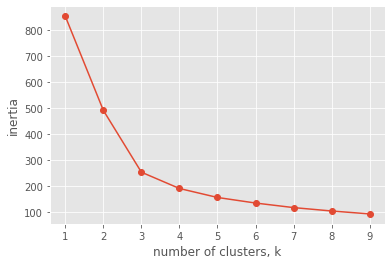

In [ ]:
# mmétodo del codo con kmeans
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_transformed)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
X=X_transformed

For n_clusters = 2 The average silhouette_score is : 0.39253442606385025
For n_clusters = 3 The average silhouette_score is : 0.4921216122898879
For n_clusters = 4 The average silhouette_score is : 0.4275258231138491
For n_clusters = 5 The average silhouette_score is : 0.410769879412164


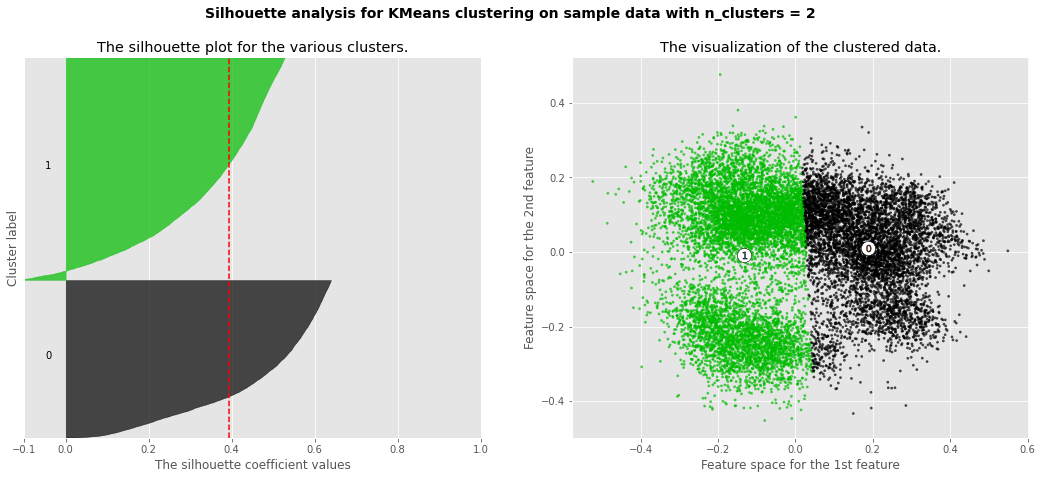

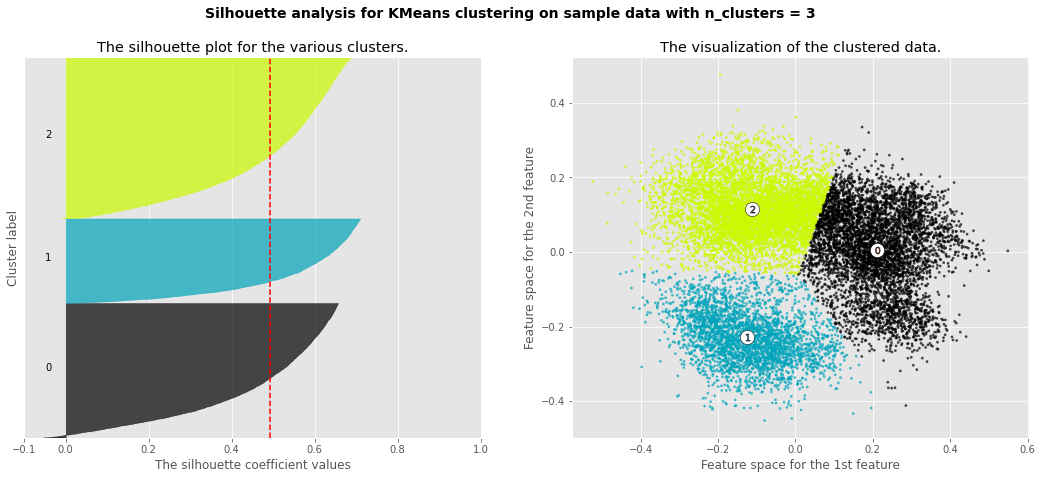

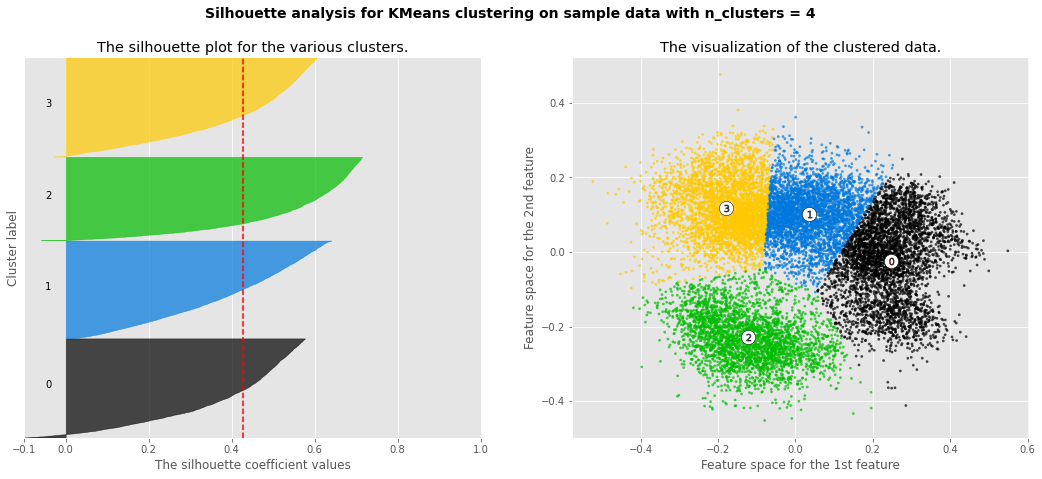

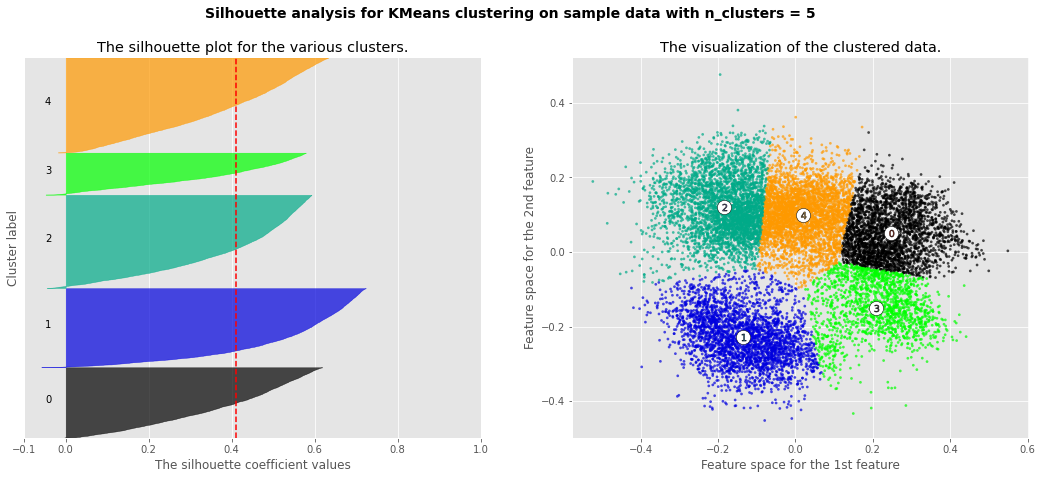

In [ ]:
# con gráfico y score de siluetas
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4,5]

for n_clusters in range_n_clusters:
    # Subplot (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1st subplot es el grafico de silueta
    # Observa que, el coeficiente de silueta está en [-1,1], pero para visualizar mejor los datos
    # lo ponemos en [-0.1, 1], ya que en este ejemplo todos caen en ese rango
    ax1.set_xlim([-0.1, 1])
    
    # ponemos un margen de (n_clusters+1)*10 entre cada silueta individual para
    # cada cluster 
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # instanciamos un objeto de KMeans, especificando n_clusters en el constructor
    # fijamos la semilla (random_state) para poder reproducir el resultado
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # el silhouette_score es el valor promedio para cada muestra ($\bar{s}_K$ en la notación de clase)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # valor de silueta para cada observacion
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # agregar el score silhouette scores para las observaciones que caen en el cluster i
        # y se ordenan
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # etiquetas de los silhouette plots
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # pone el score average silhouette como una linea puteada en rojo
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # El segundo grafico muestra los clusters formados 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    # grafica centroides
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
# asigna a un cluster
fuzzy_kmeans = FuzzyKMeans(k=3)
fuzzy_kmeans.fit(X_transformed)
pca_dataset['Labels']= fuzzy_kmeans.labels_ #etiquetas
pt=fuzzy_kmeans.fuzzy_labels_ #probabilidades
centroids=fuzzy_kmeans.cluster_centers_ #centroides
centroids.shape

(3, 2)

In [ ]:
#grafico
fig = px.scatter(pca_dataset, x='c1', y='c2', color='Labels', hover_data=['Words'], opacity=0.15)
# plot the centroids
fig.add_trace( go.Scatter(
            x=centroids[:, 0],
            y=centroids[:, 1],
            mode="markers+text",
            text=['0','1','2'],
            textposition="bottom center",
            name='Centroides',
            marker=dict(
            
            size=[20,20,20],
            color=['black', 'black', 'black']
            
            )
        
           
        ) )
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

# Tópicos más frecuentes en el cluster

In [ ]:
df=pd.read_excel('RiesgosLimpia.xlsx')

In [ ]:
def get_fecsDicst(df=pca_dataset):
  df2=df.copy()
  stops=[]
  stops.extend(STOPWORDS )
  stops.extend(stopSpanish )
  frecw0={}
  frecw1={}
  frecw2={}
  for word, label in zip(df2.Words,df2.Labels):
    if word not in stops:
      frec=word_counts[word]
      if label==0:
        frecw0[word]=frec
      elif label==1:
        frecw1[word]=frec
      elif label==2:
        frecw2[word]=frec


  return frecw0, frecw1, frecw2

def makeImage(wordC,name,maxword=10):
    x, y = np.ogrid[:300, :300]
    
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(stopSpanish) 
    my_stopwords.update(['zee'])
    wc = WordCloud(background_color='white',stopwords=my_stopwords, max_words=maxword, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(wordC)

    # show
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(str(maxword)+' tópicos más frecuentes en cluster: '+name)
    plt.axis('off')
    plt.show()
    cloudtxt.to_file(name+".png")

def plotimg(Cluster,maxword=10): 
    frecw0, frecw1, frecw2=get_fecsDicst()
    if Cluster=='0':
        cl=0
        wordC=frecw0
    elif Cluster=='1':
        cl=1
        wordC=frecw1
    elif Cluster=='2':
        cl=2
        wordC=frecw2
    

    

    print('Corpus size: '+str(len(wordC)))
    if len(wordC)>=1:
      WordCloudImg(wordC,Cluster,maxword)
    else:
      print('No hay textos en este cluster')


In [ ]:
#funcion para hacer la nube de las 50 palabras mas frecuentes
def WordCloudImg(Corpus,name,maxword=10):
    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    #junta todos los textos
    prep = " ".join(review for review in Corpus if len(review)>3 and review.isnumeric()==False )
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(stopSpanish)
    my_stopwords.update(['zee'])
    cloudtxt=WordCloud(background_color='white',stopwords=my_stopwords, max_words=maxword, mask=mask).generate(prep)
    plt.figure(figsize=(10,10))
    plt.imshow(cloudtxt,interpolation='bilinear')
    plt.title(str(maxword)+' Palabras más frecuentes en cluster: '+name)
    plt.axis('off')
    plt.show()
    cloudtxt.to_file(name+".png")

def plotimg(Cluster,maxword=10): 
    TestDF=df.copy() 
    if Cluster=='0':
        cl=0
        filtered=TestDF[(TestDF.TopicCluster==cl) ]
    elif Cluster=='1':
        cl=1
        filtered=TestDF[(TestDF.TopicCluster==cl) & (TestDF.riesgo=='Baja') ]
    elif Cluster=='2':
        cl=2
        filtered=TestDF[(TestDF.TopicCluster==cl) & (TestDF.riesgo=='Alza') ]
    

    Textos=filtered['texto'].values #documentos
    Corpus=[]
    for texto in Textos:
      palabras=word_tokenize(texto)
      Corpus.extend(palabras)

    print('Corpus size: '+str(len(Corpus)))
    if len(Corpus)>=1:
      WordCloudImg(Corpus,Cluster,maxword)
    else:
      print('No hay textos en este cluster')

In [ ]:
interact(plotimg,Cluster=['0', '1', '2'],maxword=[10,100,1000]) #tarda un poco...

interactive(children=(Dropdown(description='Cluster', options=('0', '1', '2'), value='0'), Dropdown(descriptio…

<function __main__.plotimg>

# Observaciones:
- 0 gobierno y empresas 
- 1 politico, narco, inseguridad 
- 2 estabilidad 

## Frecuencias de que los documentos sean a la alza o a la baja dado que han caido en el cluster i

In [ ]:
df.riesgo.value_counts()

Baja    19849
Alza    16046
Name: riesgo, dtype: int64

In [ ]:
np.round(df[df.TopicCluster==0].riesgo.value_counts()/len(df[df.TopicCluster==0])*100,2) #cluster0 

Baja    56.04
Alza    43.96
Name: riesgo, dtype: float64

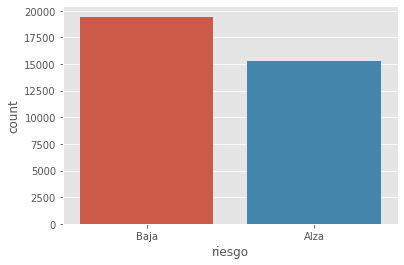

In [ ]:
sns.countplot(x='riesgo',data=df[df.TopicCluster==0],  order=df[df.TopicCluster==0].riesgo.value_counts().index)
plt.show()

In [ ]:
df[df.TopicCluster==1].riesgo.value_counts()/len(df[df.TopicCluster==1]) #para el cluster 1

Baja    0.555556
Alza    0.444444
Name: riesgo, dtype: float64

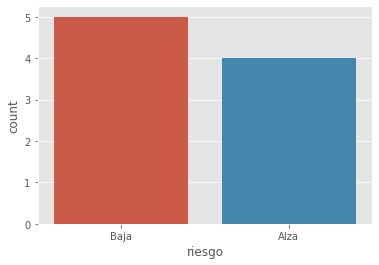

In [ ]:
sns.countplot(x='riesgo',data=df[df.TopicCluster==1],  order=df[df.TopicCluster==1].riesgo.value_counts().index)
plt.show()

In [ ]:
np.round(df[df.TopicCluster==2].riesgo.value_counts()/len(df[df.TopicCluster==2])*100,2) #cluster2

Alza    66.25
Baja    33.75
Name: riesgo, dtype: float64

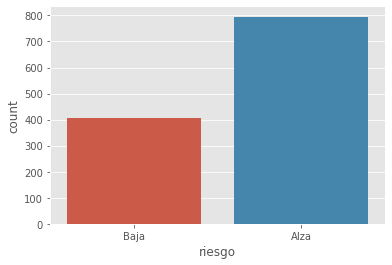

In [ ]:
sns.countplot(x='riesgo',data=df[df.TopicCluster==2],order=['Baja','Alza'])
plt.show()

In [ ]:
#seleccionamos por separado todos los de a la alza y a la baja
up=df[df.riesgo=='Alza'].index.values
down=df[df.riesgo=='Baja'].index.values

In [ ]:
baja0=[]
alza0=[]

baja1=[]
alza1=[]

baja2=[]
alza2=[]

for i in range(0,1000): #repite 1000 veces el experimento
  #experimento
  #se toma un tamaño de muestra grande del mismo tamaño, aleatorio y sin reemplazo para ambos
  TamañoMuestra=16046 # aprox el 90% del tamaño de a la alza
  upbalance=np.random.choice(up,TamañoMuestra, replace=False)
  downbalance=np.random.choice(down,TamañoMuestra, replace=False)
  dfdown=df.loc[downbalance]
  dfup=df.loc[upbalance]
  #se  crea un sólo dataframe balanceado
  df2=pd.concat([dfdown,dfup])

  #vemos las frecuencias en cada cluster
  cl0=df2[df2.TopicCluster==0].riesgo.value_counts()/len(df2[df2.TopicCluster==0]) #cluster0
  cl1=df2[df2.TopicCluster==1].riesgo.value_counts()/len(df2[df2.TopicCluster==1]) #cluster1
  cl2=df2[df2.TopicCluster==2].riesgo.value_counts()/len(df2[df2.TopicCluster==2]) #cluster2

  try:
    c0b=cl0['Baja']
    

  except:
    c0b=0.0
    

  try:
    
    c0a=cl0['Alza']

  except:
    
    c0a=0.0
    
  try:
    c1b=cl1['Baja']
    
    
  except:
    c1b=0.0
    

  try:
    
    c1a=cl1['Alza']
    
  except:
    
    c1a=0.0
    
  try:
    c2b=cl2['Baja']
    
    
  except:
    c2b=0.0
    
  
  try:
    
    c2a=cl2['Alza']
    
  except:
    
    c2a=0.0

  #guarda los resultados
  baja0.append(c0b)
  baja1.append(c1b)
  baja2.append(c2b)

  alza0.append(c0a)
  alza1.append(c1a)
  alza2.append(c2a)


baja0=np.array(baja0)
alza0=np.array(alza0)

baja1=np.array(baja1)
alza1=np.array(alza1)

baja2=np.array(baja2)
alza2=np.array(alza2)

In [ ]:
resdict={'baja0':baja0,
         'baja1': baja1,
         'baja2':baja2,
         'alza0':alza0,
         'alza1':alza1,
         'alza2':alza2}

resdf=pd.DataFrame(resdict)

In [ ]:
resdf.describe() #se toman las medias

,baja0,baja1,baja2,alza0,alza1,alza2
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.507555,0.497117,0.291474,0.492445,0.502883,0.708526
std,0.000127,0.059102,0.005016,0.000127,0.059102,0.005016
min,0.507192,0.200000,0.273973,0.492029,0.444444,0.693717
25%,0.507462,0.500000,0.288272,0.492363,0.444444,0.705413
50%,0.507558,0.500000,0.291444,0.492442,0.500000,0.708556
75%,0.507637,0.555556,0.294587,0.492538,0.500000,0.711728
max,0.507971,0.555556,0.306283,0.492808,0.800000,0.726027


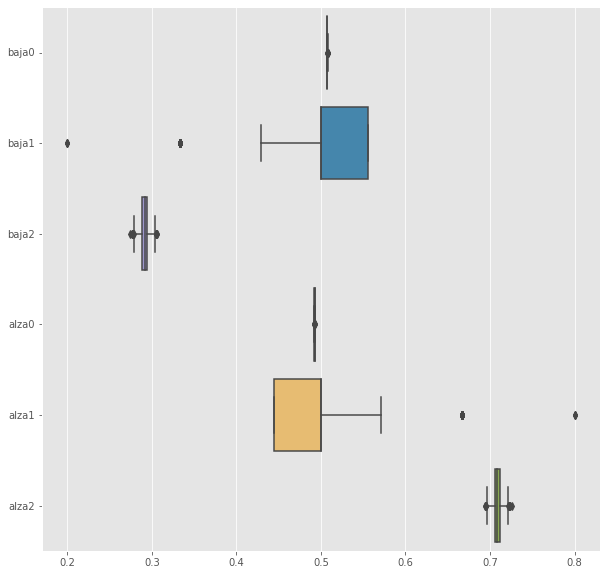

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=resdf,orient="h") #boxplot horizontal